<center> <h1> A Pizza the Profit </h1> </center>
<center> <h2> Sales Regression Analysis for a local Pizza franchise </center> </h2> 
<center> <img src="./Images/ivan-torres-MQUqbmszGGM-unsplash.jpg" alt="Pizza" width="800"/> </center>
<center> Photo by <a href="https://unsplash.com/@iavnt?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Ivan Torres</a> on <a href="https://unsplash.com/s/photos/pizza?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a></center>




## Stakeholder & Business Problem: A local pizza franchise looking to bring in new customers and encourage existing customers to continue returning. It is my goal to identify if a specific discount code is the most likely to increase sales and by what amount.

#### The null hypothesis is that the independent variables (in our case, the discount codes and values) together do not explain any variability in the dependent variable (net sales). 
#### The alternate hypothesis is that the discount codes can explain variability in net sales.
#### 45 independent variables, including a constant.

### Final Modeling

After running preliminary modeling and analysis, it is determined that the models cannot be utilized for business decisions due to violations in linear regression assumptions. This notebook is dedicated to reworking and transforming the data, as well as reducing the number of features to a meaningful but still informative set for analysis and final predictive modeling.

In [1]:
#importing needed libraries, as well as additional libraries with potential for utilization
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, BayesianRidge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.model_selection import train_test_split, cross_validate
import statsmodels.api as sm
from statsmodels.api import OLS

In [2]:
#call in all of my pickles 
discounted_orders = pd.read_pickle('./Pickles/disc_orders_ohe')
total_sales = pd.read_pickle('./Pickles/total_sales')
total_marketing = pd.read_pickle('./Pickles/total_marketing')
marketing_condensed = pd.read_pickle('./Pickles/total_marketing_condensed')

In [3]:
#train test split and add constant to X for modeling - Dropping Items Ordered for initial model - will assess 
#predictive value of specific items separately if time allows

X = discounted_orders.drop(columns=['Net Sales', 'Items Ordered'])
y = discounted_orders['Net Sales']
X = sm.add_constant(X)

X_train_val, X_val, y_train_val, y_val = train_test_split(X, y, test_size=0.25, random_state=123)

In [4]:
#Secondary split to set X_test and y_test aside to the very end as final holdout for best model.

X_train, X_test, y_train, y_test = train_test_split(X_val, y_val, test_size=0.10, random_state=123)

In [5]:
#Apply scaling
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train_val)
X_val_scaled = ss.transform(X_val)
X_test_scaled = ss.transform(X_test)

In [6]:
baseline = LinearRegression()
baseline.fit(X_train_val, y_train_val)
print("Unscaled training score:", baseline.score(X_train_val, y_train_val))
print("Unscaled validation score:", baseline.score(X_val, y_val))

Unscaled training score: 0.4608779370806717
Unscaled validation score: 0.47354111068497284


In [7]:
baseline2 = LinearRegression()
baseline2.fit(X_train_scaled, y_train_val)
print("Scaled training score:", baseline2.score(X_train_scaled, y_train_val))
print("Scaled validation score:", baseline2.score(X_val_scaled, y_val))

Scaled training score: 0.4604666761842654
Scaled validation score: -2.811655253895033e+24


In [8]:
#apply log transformations to normalize the continuous target + 1 to avoid -inf values
y_train_val_log = np.log(y_train_val + 1)
y_val_log = np.log(y_val + 1)
y_test_log = np.log(y_test + 1)
X_log_train = np.log(X_train_val['Total Discount Amount'] + 1)
X_log_val = np.log(X_val['Total Discount Amount'] + 1)
X_train_val_log = X_train_val.copy()
X_val_log = X_val.copy()
X_train_val_log['Total Discount Amount'] = X_log_train
X_val_log['Total Discount Amount'] = X_log_val

In [9]:
#test fit on log scaled target
mod = sm.OLS(y_train_val_log, X_train_val_log).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Net Sales   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     85.09
Date:                Mon, 07 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:11:09   Log-Likelihood:                -3594.7
No. Observations:                3903   AIC:                             7275.
Df Residuals:                    3860   BIC:                             7545.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                           1.1661      0.065     17.990      0.000       1.039       1.293
Total Discount Amount                           0.5516      0.022     25.315      0.000       0.509       0.594
Discount Code_$4 Off Any Pizza                  1.0026      0.095     10.604      0.000       0.817       1.188
Discount Code_100% Off                         -1.0958      0.107    -10.260      0.000      -1.305      -0.886
Discount Code_35% Off 3 Large Pizzas            0.6619      0.165      4.019      0.000       0.339       0.985
Discount Code_7-7-7 Deal                        0.5490      0.082      6.733      0.000       0.389       0.709
Discount Code_Bogo                              0.0318      0.229      0.139      0.889      -0.417       0.481
Discount Code_COLRG1                            0.3730      0.092      4.054      0.000       0.193       0.553
Discount Code_COLRG2                            0.3266      0.424      0.771      0.441      -0.504       1.157
Discount Code_Coupon                            0.3532      0.247      1.432      0.152      -0.130       0.837
Discount Code_DMDIN3                            0.9493      0.099      9.614      0.000       0.756       1.143
Discount Code_DMFAV1                            0.8873      0.193      4.607      0.000       0.510       1.265
Discount Code_DMMED2                            0.3305      0.099      3.348      0.001       0.137       0.524
Discount Code_DMMED3                            0.7907      0.154      5.136      0.000       0.489       1.093
Discount Code_DMPAIR1                           0.9690      0.085     11.446      0.000       0.803       1.135
Discount Code_Employee Discount                -0.1653      0.214     -0.771      0.441      -0.586       0.255
Discount Code_FREE MED 1 TOP                    0.3591      0.139      2.590      0.010       0.087       0.631
Discount Code_FREEMDM                           0.7477      0.184      4.066      0.000       0.387       1.108
Discount Code_Food Drive Deal                  -0.8452      0.347     -2.438      0.015      -1.525      -0.165
Discount Code_Free Birthday Pizza              -1.9121      0.184    -10.394      0.000      -2.273      -1.551
Discount Code_Free Large Pizza Card            -1.2556      0.143     -8.785      0.000      -1.536      -0.975
Discount Code_Free Large pizza coupon           0.4127      0.598      0.690      0.490      -0.760       1.585
Discount Code_Free birthday pizza              -2.7899      0.598     -4.665      0.000      -3.962      -1.617
Discount Code_Free large pizza coupon          -1.5906      0.301     -5.280      0.000      -2.181      -1.000
Discount Code_Free pizza coupon                -2.7786     

### Assumptions 

As previously cited in the preliminary modeling notebook, code from Jeff Macaluso to test linear regression assumptions simultaneously. [Source here](https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/) Reminder that the assumptions for linear regression are Linearity, Normality (normal distribution of the residuals), no multicollinearity, no autocorrelation of the residuals, and homoscedasticity or equal variance in the residuals.

- Even after applying log transformations to the continuous variables, I still cannot get the residuals to be homoscedastic and normally distributed. This will need to be addressed in future analysis steps due to time constraints.

- Utilizing the Recursive Feature Elimination Grid Search, I am able to completely eliminate the multicollinearity issue while still maintaining the majority of the features for modeling.

- Remaining assumptions are met. The violated assumptions to be addressed in Future Analysis and Limitations.

In [10]:
#long function to run the assumption assessment on the log transformed data to assess improvement.
def linear_regression_assumptions(features, label, feature_names=None):
    """
    Tests a linear regression on the model to see if assumptions are being met
    """
    from sklearn.linear_model import LinearRegression
    
    # Setting feature names to x1, x2, x3, etc. if they are not defined
    if feature_names is None:
        feature_names = ['X'+str(feature+1) for feature in range(features.shape[1])]
    
    print('Fitting linear regression')
    # Multi-threading if the dataset is a size where doing so is beneficial
    if features.shape[0] < 100000:
        model = LinearRegression(n_jobs=-1)
    else:
        model = LinearRegression()
        
    model.fit(features, label)
    
    # Returning linear regression R^2 and coefficients before performing diagnostics
    r2 = model.score(features, label)
    print()
    print('R^2:', r2, '\n')
    print('Coefficients')
    print('-------------------------------------')
    print('Intercept:', model.intercept_)
    
    for feature in range(len(model.coef_)):
        print('{0}: {1}'.format(feature_names[feature], model.coef_[feature]))

    print('\nPerforming linear regression assumption testing')
    
    # Creating predictions and calculating residuals for assumption tests
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])

    
    def linear_assumption():
        """
        Linearity: Assumes there is a linear relationship between the predictors and
                   the response variable. If not, either a polynomial term or another
                   algorithm should be used.
        """
        print('\n=======================================================================================')
        print('Assumption 1: Linear Relationship between the Target and the Features')
        
        print('Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.')
        
        # Plotting the actual vs predicted values
        sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
        # Plotting the diagonal line
        line_coords = np.arange(df_results.min().min(), df_results.max().max())
        plt.plot(line_coords, line_coords,  # X and y points
                 color='darkorange', linestyle='--')
        plt.title('Actual vs. Predicted')
        plt.show()
        print('If non-linearity is apparent, consider adding a polynomial term')
        
        
    def normal_errors_assumption(p_value_thresh=0.05):
        """
        Normality: Assumes that the error terms are normally distributed. If they are not,
        nonlinear transformations of variables may solve this.
               
        This assumption being violated primarily causes issues with the confidence intervals
        """
        from statsmodels.stats.diagnostic import normal_ad
        print('\n=======================================================================================')
        print('Assumption 2: The error terms are normally distributed')
        print()
    
        print('Using the Anderson-Darling test for normal distribution')

        # Performing the test on the residuals
        p_value = normal_ad(df_results['Residuals'])[1]
        print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
        # Reporting the normality of the residuals
        if p_value < p_value_thresh:
            print('Residuals are not normally distributed')
        else:
            print('Residuals are normally distributed')
    
        # Plotting the residuals distribution
        plt.subplots(figsize=(12, 6))
        plt.title('Distribution of Residuals')
        sns.distplot(df_results['Residuals'])
        plt.show()
    
        print()
        if p_value > p_value_thresh:
            print('Assumption satisfied')
        else:
            print('Assumption not satisfied')
            print()
            print('Confidence intervals will likely be affected')
            print('Try performing nonlinear transformations on variables')
        
        
    def multicollinearity_assumption():
        """
        Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                           correlation among the predictors, then either remove prepdictors with high
                           Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                           This assumption being violated causes issues with interpretability of the 
                           coefficients and the standard errors of the coefficients.
        """
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        print('\n=======================================================================================')
        print('Assumption 3: Little to no multicollinearity among predictors')
        
        # Plotting the heatmap
        plt.figure(figsize = (10,8))
        sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
        plt.title('Correlation of Variables')
        plt.show()
        
        print('Variance Inflation Factors (VIF)')
        print('> 10: An indication that multicollinearity may be present')
        print('> 100: Certain multicollinearity among the variables')
        print('-------------------------------------')
       
        # Gathering the VIF for each variable
        VIF = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
        for idx, vif in enumerate(VIF):
            print('{0}: {1}'.format(feature_names[idx], vif))
        
        # Gathering and printing total cases of possible or definite multicollinearity
        possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
        definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
        print()
        print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
        print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
        print()

        if definite_multicollinearity == 0:
            if possible_multicollinearity == 0:
                print('Assumption satisfied')
            else:
                print('Assumption possibly satisfied')
                print()
                print('Coefficient interpretability may be problematic')
                print('Consider removing variables with a high Variance Inflation Factor (VIF)')
        else:
            print('Assumption not satisfied')
            print()
            print('Coefficient interpretability will be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')
        
        
    def autocorrelation_assumption():
        """
        Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                         autocorrelation, then there is a pattern that is not explained due to
                         the current value being dependent on the previous value.
                         This may be resolved by adding a lag variable of either the dependent
                         variable or some of the predictors.
        """
        from statsmodels.stats.stattools import durbin_watson
        print('\n=======================================================================================')
        print('Assumption 4: No Autocorrelation')
        print('\nPerforming Durbin-Watson Test')
        print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
        print('0 to 2< is positive autocorrelation')
        print('>2 to 4 is negative autocorrelation')
        print('-------------------------------------')
        durbinWatson = durbin_watson(df_results['Residuals'])
        print('Durbin-Watson:', durbinWatson)
        if durbinWatson < 1.5:
            print('Signs of positive autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            print('Consider adding lag variables')
        elif durbinWatson > 2.5:
            print('Signs of negative autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            print('Consider adding lag variables')
        else:
            print('Little to no autocorrelation', '\n')
            print('Assumption satisfied')

            
    def homoscedasticity_assumption():
        """
        Homoscedasticity: Assumes that the errors exhibit constant variance
        """
        print('\n=======================================================================================')
        print('Assumption 5: Homoscedasticity of Error Terms')
        print('Residuals should have relative constant variance')
        
        # Plotting the residuals
        plt.subplots(figsize=(12, 6))
        ax = plt.subplot(111)  # To remove spines
        plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
        plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
        ax.spines['right'].set_visible(False)  # Removing the right spine
        ax.spines['top'].set_visible(False)  # Removing the top spine
        plt.title('Residuals')
        plt.show() 
        print('If heteroscedasticity is apparent, confidence intervals and predictions will be affected')
        
        
    linear_assumption()
    normal_errors_assumption()
    multicollinearity_assumption()
    autocorrelation_assumption()
    homoscedasticity_assumption()

Fitting linear regression

R^2: 0.49602787256003456 

Coefficients
-------------------------------------
Intercept: 2686790224474.9136
X1: -34560582.09322743
X2: 1.4214723801710374
X3: -2686755663878.456
X4: -2686755663914.0454
X5: -2686755663884.9976
X6: -2686755663888.229
X7: 507761265170.05634
X8: -2686755663887.124
X9: -264101485639.27618
X10: -2686755663912.869
X11: -2686755663875.691
X12: -2686755663877.4404
X13: -2686755663890.2114
X14: -2686755663881.2324
X15: -2686755663877.184
X16: -2686755663894.679
X17: -2686755663891.7944
X18: -2686755663879.761
X19: -2686755663880.7817
X20: -2686755663911.9966
X21: -2686755663907.2876
X22: -2686755663918.506
X23: -2686755663916.2617
X24: -2686755663921.584
X25: 111623564179.65263
X26: 48091146960.23912
X27: -2686755663886.8784
X28: -2686755663882.6147
X29: -2686755663897.049
X30: -2686755663912.1763
X31: -2686755663878.064
X32: -2686755663879.9756
X33: -2686755663880.1772
X34: 195293909892.86606
X35: -2686755663876.14
X36: -2686755663886.

/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


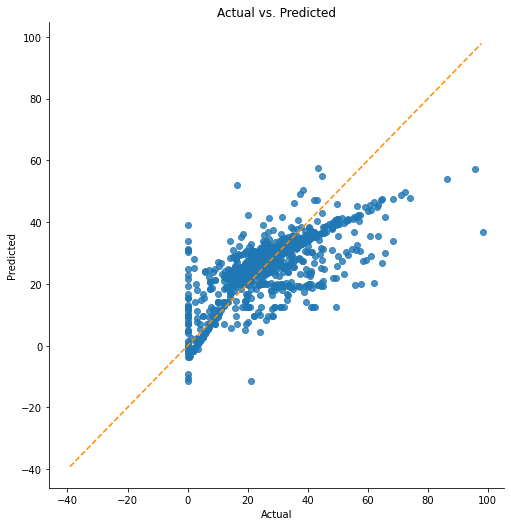

If non-linearity is apparent, consider adding a polynomial term

Assumption 2: The error terms are normally distributed

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


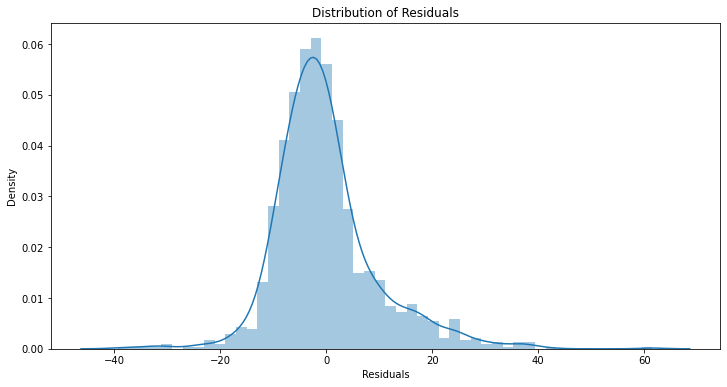


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables

Assumption 3: Little to no multicollinearity among predictors


/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/matrix.py:204: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/matrix.py:209: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


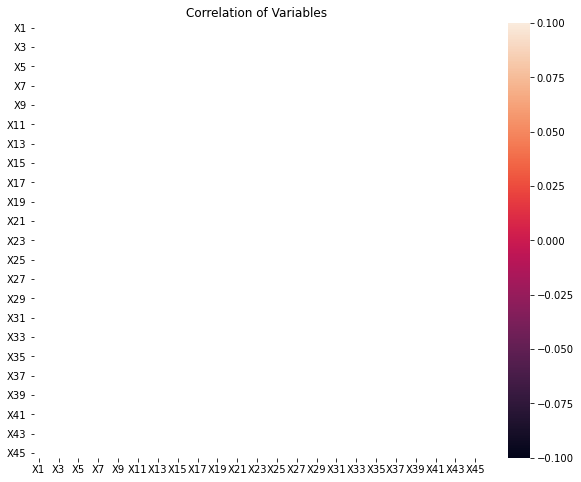

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------


/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


X1: 0.0
X2: 1.416102650916383
X3: inf
X4: inf
X5: inf
X6: inf
X7: nan
X8: inf
X9: nan
X10: inf
X11: inf
X12: inf
X13: inf
X14: inf
X15: inf
X16: inf
X17: inf
X18: inf
X19: inf
X20: inf
X21: inf
X22: inf
X23: inf
X24: inf
X25: nan
X26: nan
X27: inf
X28: inf
X29: inf
X30: inf
X31: inf
X32: inf
X33: inf
X34: nan
X35: inf
X36: inf
X37: inf
X38: inf
X39: inf
X40: inf
X41: inf
X42: inf
X43: inf
X44: inf
X45: inf

38 cases of possible multicollinearity
38 cases of definite multicollinearity

Assumption not satisfied

Coefficient interpretability will be problematic
Consider removing variables with a high Variance Inflation Factor (VIF)

Assumption 4: No Autocorrelation

Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 2.0876554289955407
Little to no autocorrelation 

Assumption satisfied

Assumption 5: Hom

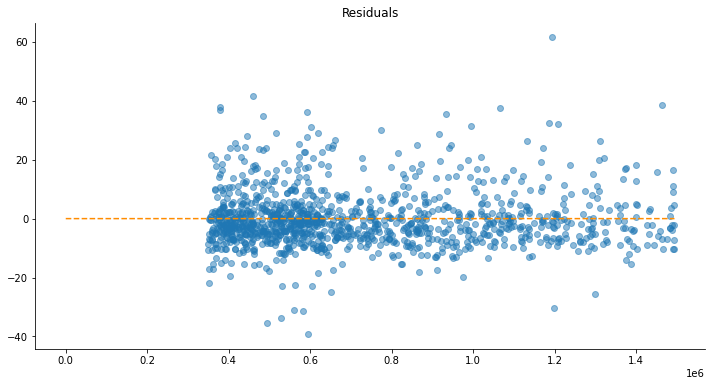

If heteroscedasticity is apparent, confidence intervals and predictions will be affected


In [11]:
#baseline check of assumption violation.
linear_regression_assumptions(X_train, y_train, feature_names=None)

Fitting linear regression

R^2: 0.5551556193897211 

Coefficients
-------------------------------------
Intercept: 494282815055.12256
X1: -14866435.649861556
X2: 0.592924846619066
X3: -494267948617.4742
X4: -494267948620.41034
X5: -494267948617.65674
X6: -494267948617.8144
X7: 349862254569.0479
X8: -494267948618.04474
X9: 318051770412.71423
X10: -494267948619.5991
X11: -494267948617.3714
X12: -494267948617.4178
X13: -494267948617.99976
X14: -494267948617.5998
X15: -494267948617.493
X16: -494267948618.86035
X17: -494267948618.14105
X18: -494267948617.648
X19: -494267948617.57294
X20: -494267948619.89886
X21: -494267948619.6257
X22: -494267948619.2794
X23: -494267948621.1701
X24: -494267948621.28546
X25: -38266726.97131177
X26: 69971048.96610726
X27: -494267948617.8263
X28: -494267948617.67847
X29: -494267948618.7955
X30: -494267948619.64557
X31: -494267948617.59863
X32: -494267948617.5575
X33: -494267948617.65717
X34: -494267948621.1167
X35: -494267948617.4344
X36: -494267948617.79877
X

/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


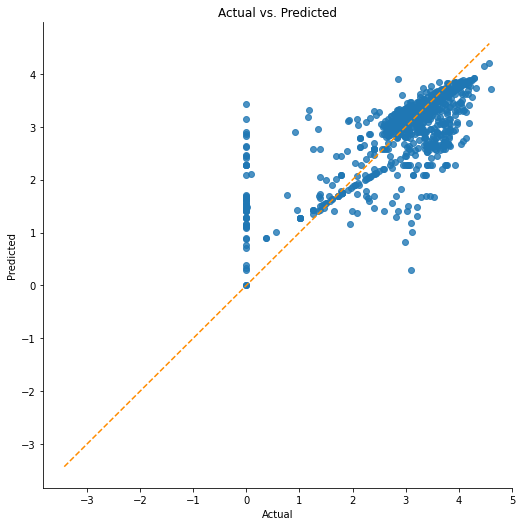

If non-linearity is apparent, consider adding a polynomial term

Assumption 2: The error terms are normally distributed

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


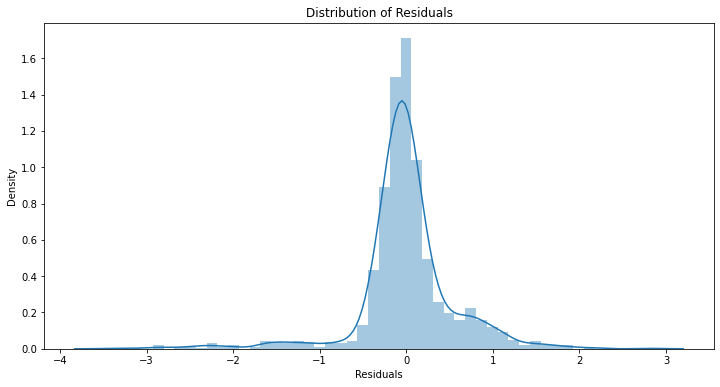


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables

Assumption 3: Little to no multicollinearity among predictors


/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/matrix.py:204: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/matrix.py:209: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


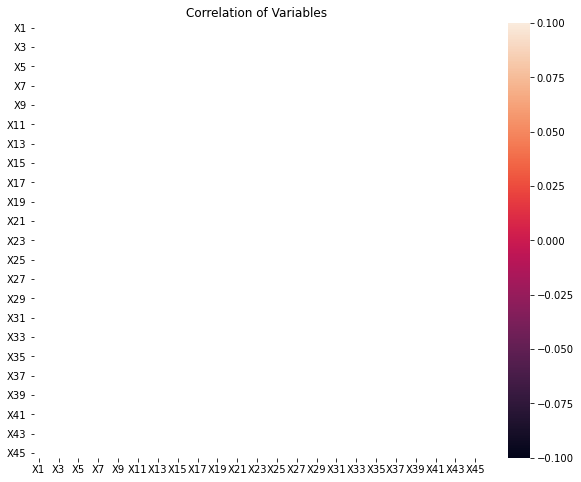

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------


/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


X1: 0.0
X2: 1.3449784892083652
X3: inf
X4: inf
X5: inf
X6: inf
X7: nan
X8: inf
X9: nan
X10: inf
X11: inf
X12: inf
X13: inf
X14: inf
X15: inf
X16: inf
X17: inf
X18: inf
X19: inf
X20: inf
X21: inf
X22: inf
X23: inf
X24: inf
X25: nan
X26: nan
X27: inf
X28: inf
X29: inf
X30: inf
X31: inf
X32: inf
X33: inf
X34: inf
X35: inf
X36: inf
X37: inf
X38: inf
X39: inf
X40: inf
X41: inf
X42: inf
X43: inf
X44: inf
X45: inf

39 cases of possible multicollinearity
39 cases of definite multicollinearity

Assumption not satisfied

Coefficient interpretability will be problematic
Consider removing variables with a high Variance Inflation Factor (VIF)

Assumption 4: No Autocorrelation

Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 2.0606785469567894
Little to no autocorrelation 

Assumption satisfied

Assumption 5: Ho

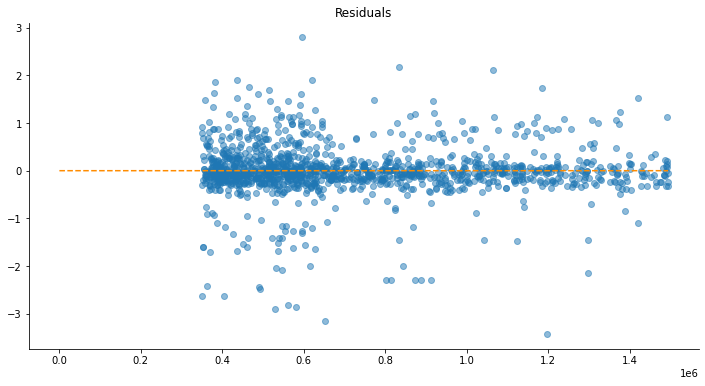

If heteroscedasticity is apparent, confidence intervals and predictions will be affected


In [12]:
#check violation on log transformed set - still violating homoscedasticity and normal distribution of residuals.
linear_regression_assumptions(X_val_log, y_val_log, feature_names=None)

# Limiting Features
Let's run models with smaller, but more important features, using Recursive Feature Elimination. 

Utilizing Recursive Feature Elimination, I've completely corrected the multicollinearity. 

### Recursive Feature Elimination

In [13]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge

In [14]:
#Run cross validation RFE to identify best features based on a Ridge model (better performance previously)
rfe_5 = RFECV(
    estimator=Ridge(),
    min_features_to_select=5,
    cv=5,
)

In [15]:
rfe_5.fit(X_train_val, y_train_val)

RFECV(cv=5, estimator=Ridge(), min_features_to_select=5)

In [16]:
#RFE identified coefficients
print(X_train_val.columns[rfe_5.support_])
print(len(X_train_val.columns[rfe_5.support_]))

Index(['Total Discount Amount', 'Discount Code_$4 Off Any Pizza',
       'Discount Code_100% Off', 'Discount Code_35% Off 3 Large Pizzas',
       'Discount Code_7-7-7 Deal', 'Discount Code_Bogo',
       'Discount Code_COLRG1', 'Discount Code_Coupon', 'Discount Code_DMDIN3',
       'Discount Code_DMFAV1', 'Discount Code_DMMED2', 'Discount Code_DMMED3',
       'Discount Code_DMPAIR1', 'Discount Code_Employee Discount',
       'Discount Code_FREEMDM', 'Discount Code_Food Drive Deal',
       'Discount Code_Free Birthday Pizza',
       'Discount Code_Free Large Pizza Card',
       'Discount Code_Free Large pizza coupon',
       'Discount Code_Free birthday pizza',
       'Discount Code_Free large pizza coupon',
       'Discount Code_Free pizza coupon', 'Discount Code_Free pizza credit',
       'Discount Code_GET25DMLG', 'Discount Code_GET25EMPLOYEE',
       'Discount Code_GET25FREE', 'Discount Code_GET25HOTEL',
       'Discount Code_GET25MILITARY', 'Discount Code_GET25MILTARY',
       'Disc

In [17]:
#create dataframe with the scores from the grid search CV and the feature names.
pd.DataFrame(
    zip(X_train_val.columns, abs(rfe_5.grid_scores_)),
    columns=["feature", "score"]).sort_values("score").reset_index(drop=True)

,feature,score
0,const,0.113554
1,Total Discount Amount,0.122029
2,Discount Code_$4 Off Any Pizza,0.136740
3,Discount Code_100% Off,0.140708
4,Discount Code_35% Off 3 Large Pizzas,0.143928
5,Discount Code_7-7-7 Deal,0.145718
6,Discount Code_COLRG1,0.149861
7,Discount Code_Bogo,0.150680
8,Discount Code_COLRG2,0.152810
9,Discount Code_Coupon,0.154033


In [18]:
#create new dfs with just the columns identified by the RFE
columns = X_train_val.columns[rfe_5.support_]
X_train_val_rfe = X_train_val[columns]
X_val_rfe = X_val[columns]
X_test_rfe = X_test[columns]

Fitting linear regression

R^2: 0.5034733010559449 

Coefficients
-------------------------------------
Intercept: 1.1118091623580213
X1: 1.427020437805988
X2: 12.772738788668853
X3: -24.366011655725774
X4: 6.609077485612008
X5: 3.382239974939693
X6: -2.4868995751603507e-13
X7: 4.904860301714932
X8: -21.27726915563999
X9: 15.983296096866992
X10: 14.235338415184119
X11: 1.1226691407326268
X12: 10.399558873728532
X13: 14.459215319137478
X14: -2.988377037661288
X15: 11.043276998016566
X16: 10.826623818221115
X17: -16.165957751441116
X18: -15.686608882268445
X19: -26.929009027517875
X20: -24.643376181778887
X21: -29.994702823551453
X22: -1.7763568394002505e-15
X23: 5.329070518200751e-15
X24: 5.170370200118158
X25: -5.125344486389751
X26: -21.080151964195224
X27: 13.035853876098912
X28: 12.11449144919233
X29: 10.848319103317575
X30: -22.502845525069823
X31: 15.74193167675278
X32: 5.460236226154064
X33: -6.9273837667044145
X34: 11.523088648612063
X35: 15.769605239398519
X36: -14.332171368575

/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


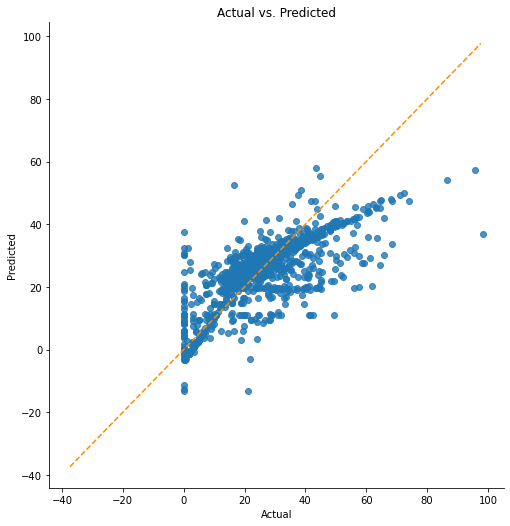

If non-linearity is apparent, consider adding a polynomial term

Assumption 2: The error terms are normally distributed

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


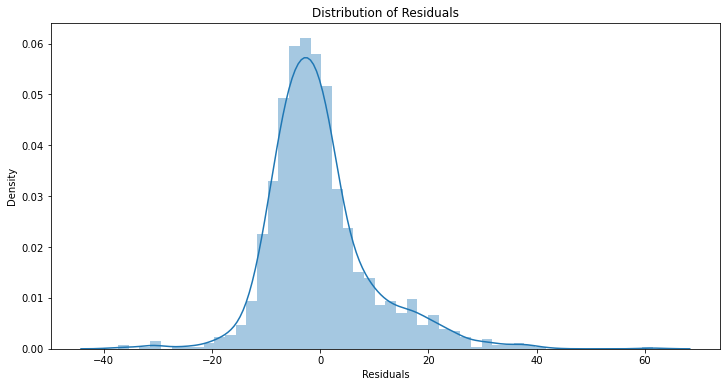


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables

Assumption 3: Little to no multicollinearity among predictors


/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/matrix.py:204: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/matrix.py:209: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


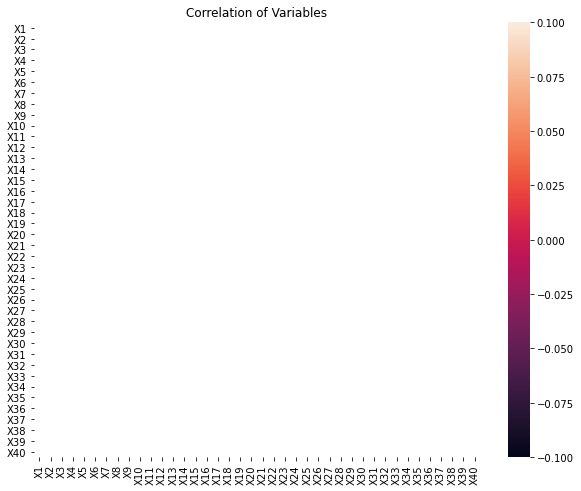

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------


/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


X1: 3.627224302595884
X2: 1.0098685890216381
X3: 1.1202624421164438
X4: 1.041506730192851
X5: 1.1892554287269375
X6: nan
X7: 1.0187595670917229
X8: 1.042425455273486
X9: 1.0185054842126207
X10: 1.0036479570625878
X11: 1.0414909131801744
X12: 1.0138354257498712
X13: 1.074544401111611
X14: 1.0016717748606898
X15: 1.027756135475623
X16: 1.006911580857178
X17: 1.0209800893678245
X18: 1.0415894540989772
X19: 1.013434268512739
X20: 1.006911580857178
X21: 1.0104125499591887
X22: nan
X23: nan
X24: 1.0121738344867535
X25: 1.1729389229940799
X26: 1.1550379979139458
X27: 1.0267945699937338
X28: 1.091025158306614
X29: 1.0268630919581776
X30: 1.00571135752659
X31: 1.2751991097439876
X32: 1.0061399023248965
X33: 1.0538228132859115
X34: 1.0025417690186118
X35: 1.8448022584049468
X36: 1.0996663625059038
X37: 1.034110142108474
X38: 1.0024838217685257
X39: 1.1052723802253748
X40: 1.0088709823000142

0 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption satisfied

Assump

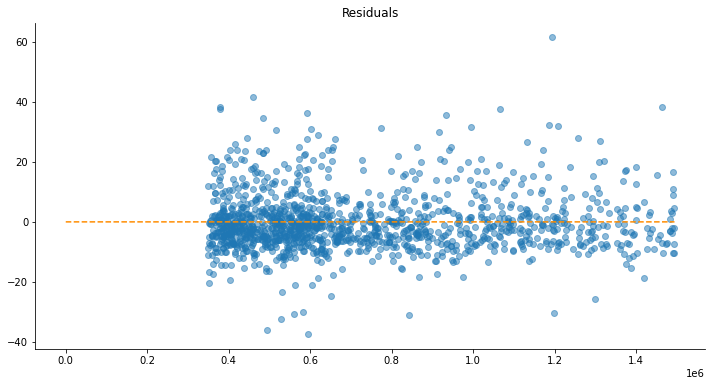

If heteroscedasticity is apparent, confidence intervals and predictions will be affected


In [19]:
#check assumuptions again
linear_regression_assumptions(X_val_rfe, y_val)

# Modeling

In [20]:
#bringing in my functions from my prelim modeling notebook
def model_score(model_list, X_tr, y_tr, x_val, y_val):
    """
    model_list: list of defined model variable names (as strings) to score
    X_tr: training data - features
    y_tr: training target
    x_val: testing or validation data - features
    y_val: testing or validation target
    """
    scores = {}
    for model in model_list:
        model.fit(X_tr, y_tr)
        train_score = model.score(X_tr, y_tr)
        val_score = model.score(x_val, y_val)
        mse = mean_squared_error(y_val, model.predict(x_val))
        rmse = (mse**0.5)
        scores[model] = ('Training R2:', train_score), ('RMSE:', rmse), ('Val R2:', val_score)
    return scores

In [21]:
#Bring in print scores function from prelim modeling notebook
def print_scores(model, X_test, y_true):
    """
    model: model/estimator name making predictions
    X_test: X_test to put in for predictions
    y_true: y_test for calculations
    """
    preds = model.predict(X_test)
    mse = mean_squared_error(y_true, preds)
    mae = mean_absolute_error(y_true, preds)
    rmse = (mse**0.5)
    exp_var = explained_variance_score(y_true, preds)
    r_score = r2_score(y_true, preds)
    print(f'MSE:',mse, 'RMSE:',rmse, 'MAE:',mae, 'R2:',r_score, 'Exp Variance:',exp_var)

In [22]:
from sklearn.ensemble import RandomForestRegressor,VotingRegressor, GradientBoostingRegressor
#score baseline models run previously
rf = RandomForestRegressor(random_state=123)
gb = GradientBoostingRegressor(random_state=123)
nb = BayesianRidge()
lr = LinearRegression()
rr = Ridge(random_state=123)

models = [rf, gb, nb, lr, rr]
model_score(models, X_train_val, y_train_val, X_val, y_val)

{RandomForestRegressor(random_state=123): (('Training R2:',
   0.7892086733138686),
  ('RMSE:', 9.016295770640738),
  ('Val R2:', 0.5666582399337012)),
 GradientBoostingRegressor(random_state=123): (('Training R2:',
   0.6346793568564433),
  ('RMSE:', 8.796678276611201),
  ('Val R2:', 0.5875116752871099)),
 BayesianRidge(): (('Training R2:', 0.4602653693112472),
  ('RMSE:', 9.92496865258007),
  ('Val R2:', 0.4749114712281971)),
 LinearRegression(): (('Training R2:', 0.4608779370806717),
  ('RMSE:', 9.937911158955407),
  ('Val R2:', 0.47354111068497284)),
 Ridge(random_state=123): (('Training R2:', 0.45955106252693534),
  ('RMSE:', 9.92258181073436),
  ('Val R2:', 0.4751639964732559))}

In [23]:
#check with the reduced feature set identified by RFE - scores improved 
model_score(models, X_train_val_rfe, y_train_val, X_val_rfe, y_val)

{RandomForestRegressor(random_state=123): (('Training R2:',
   0.7869235293813405),
  ('RMSE:', 8.987499164777088),
  ('Val R2:', 0.5694218680545176)),
 GradientBoostingRegressor(random_state=123): (('Training R2:',
   0.6221082002666758),
  ('RMSE:', 8.777168895960656),
  ('Val R2:', 0.5893392896856489)),
 BayesianRidge(): (('Training R2:', 0.46027859575120367),
  ('RMSE:', 9.924417547013833),
  ('Val R2:', 0.4749697829845151)),
 LinearRegression(): (('Training R2:', 0.46083302481396726),
  ('RMSE:', 9.93619641983838),
  ('Val R2:', 0.4737227709463433)),
 Ridge(random_state=123): (('Training R2:', 0.45953170574769764),
  ('RMSE:', 9.921225950752977),
  ('Val R2:', 0.4753074179192813))}

In [24]:
#bring in tree param function from other notebook
def find_tree_params(model_list, X_tr, y_tr, folds):
    """
    model_list: list of defined models you want to try out, but make sure params are searchable with this grid
    X_tr and y_tr: training data
    folds = int of cross val folds to perform
    """
    for model in model_list:
        search_results= {}
        grid = {'n_estimators': [50, 100, 150],
                'max_depth': [3, 5, 7], 
                'min_samples_leaf': [1, 3, 5],
                'random_state': [123] 
    
}
        model = GridSearchCV(model, grid, cv=folds)
        model.fit(X_tr, y_tr)
        search_results[model] = model.best_params_
        search_results[model]['Score'] = model.best_score_
        print(search_results)

In [25]:
#tune to see if I can improve these scores
from sklearn.model_selection import GridSearchCV
search = [rf, gb]
find_tree_params(search, X_train_val_rfe, y_train_val, 5)

{GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=123),
             param_grid={'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 3, 5],
                         'n_estimators': [50, 100, 150],
                         'random_state': [123]}): {'max_depth': 7, 'min_samples_leaf': 5, 'n_estimators': 150, 'random_state': 123, 'Score': 0.5396452456437881}}
{GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=123),
             param_grid={'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 3, 5],
                         'n_estimators': [50, 100, 150],
                         'random_state': [123]}): {'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 100, 'random_state': 123, 'Score': 0.5602141060927224}}


In [26]:
#score models again to see if improvements are made - add VotingRegressor
tuned_rf = RandomForestRegressor(random_state=123, max_depth=7, min_samples_leaf=5, n_estimators=150)
tuned_gb = GradientBoostingRegressor(random_state=123, max_depth=5, min_samples_leaf=5, n_estimators=100)
voter = VotingRegressor([("gb", gb), ("rf", rf), ("tuned_rf", tuned_rf), ("lr", lr), 
                         ('bayes', nb), ('ridge', rr), ('tuned_gb', tuned_gb)])
model_iter = [rf, gb, nb, lr, rr, tuned_gb, tuned_rf, voter]

In [27]:
model_score(model_iter, X_train_val_rfe, y_train_val, X_val_rfe, y_val)

{RandomForestRegressor(random_state=123): (('Training R2:',
   0.7869235293813405),
  ('RMSE:', 8.987499164777088),
  ('Val R2:', 0.5694218680545176)),
 GradientBoostingRegressor(random_state=123): (('Training R2:',
   0.6221082002666758),
  ('RMSE:', 8.777168895960656),
  ('Val R2:', 0.5893392896856489)),
 BayesianRidge(): (('Training R2:', 0.46027859575120367),
  ('RMSE:', 9.924417547013833),
  ('Val R2:', 0.4749697829845151)),
 LinearRegression(): (('Training R2:', 0.46083302481396726),
  ('RMSE:', 9.93619641983838),
  ('Val R2:', 0.4737227709463433)),
 Ridge(random_state=123): (('Training R2:', 0.45953170574769764),
  ('RMSE:', 9.921225950752977),
  ('Val R2:', 0.4753074179192813)),
 GradientBoostingRegressor(max_depth=5, min_samples_leaf=5, random_state=123): (('Training R2:',
   0.6579537693377915),
  ('RMSE:', 8.501333679821277),
  ('Val R2:', 0.6147449248661874)),
 RandomForestRegressor(max_depth=7, min_samples_leaf=5, n_estimators=150,
                       random_state=123):

In [28]:
#remove weak learners/duplicate model types from VotingRegressor and rerun
voter2 = VotingRegressor([("tuned_rf", tuned_rf), ('ridge', rr), ('tuned_gb', tuned_gb)])
model_iter_2 = [voter2, tuned_rf, rr, tuned_gb]
model_score(model_iter_2, X_train_val_rfe, y_train_val, X_val_rfe, y_val)

{VotingRegressor(estimators=[('tuned_rf',
                              RandomForestRegressor(max_depth=7,
                                                    min_samples_leaf=5,
                                                    n_estimators=150,
                                                    random_state=123)),
                             ('ridge', Ridge(random_state=123)),
                             ('tuned_gb',
                              GradientBoostingRegressor(max_depth=5,
                                                        min_samples_leaf=5,
                                                        random_state=123))]): (('Training R2:',
   0.6164763507428375),
  ('RMSE:', 8.52452694303063),
  ('Val R2:', 0.6126399584383442)),
 RandomForestRegressor(max_depth=7, min_samples_leaf=5, n_estimators=150,
                       random_state=123): (('Training R2:',
   0.5861070086746014),
  ('RMSE:', 8.980952827377116),
  ('Val R2:', 0.5700488907952466)),
 Ridge(random_

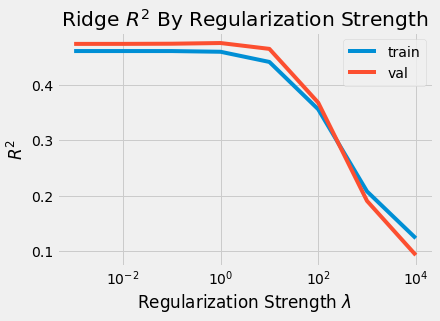

In [29]:
#check for optimal values on RidgeRegression prior to bringing in the stacking method
from sklearn.linear_model import Ridge
alphas = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10_000]
train_scores = []
val_scores = []
rmse_scores = []

for alpha in alphas:
    ridger = Ridge(alpha=alpha, random_state=123)
    ridger.fit(X_train_val_rfe, y_train_val)
    train_score = ridger.score(X_train_val_rfe, y_train_val)
    val_score = ridger.score(X_val_rfe, y_val)
    mse = mean_squared_error(y_val, ridger.predict(X_val_rfe))
    rmse = (mse**0.5)
    train_scores.append(train_score)
    val_scores.append(val_score)
    rmse_scores.append(rmse)
    
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
plt.xscale('log')
plt.title('Ridge $R^2$ By Regularization Strength')
ax.set_xlabel('Regularization Strength $\lambda$')
ax.set_ylabel('$R^2$')
ax.plot(alphas, train_scores, label='train')
ax.plot(alphas, val_scores, label='val')
#ax.plot(alphas, rmse_scores, label= 'val RMSE')
plt.legend();
#optimal .01 reg strength

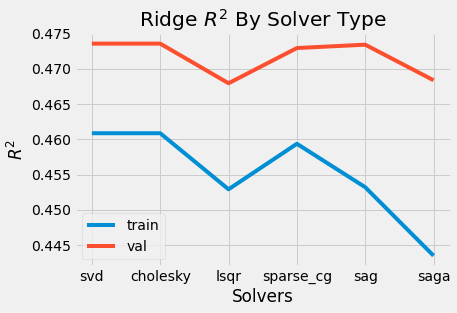

In [30]:
#find optimal solver
solvers = ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
train_scores = []
val_scores = []
rmse_scores = []

for solver in solvers:
    ridge = Ridge(alpha=.01, solver=solver, random_state=123)
    ridge.fit(X_train_val, y_train_val)
    train_score = ridge.score(X_train_val, y_train_val)
    val_score = ridge.score(X_val, y_val)
    mse = mean_squared_error(y_val, ridge.predict(X_val))
    rmse = (mse**0.5)
    train_scores.append(train_score)
    val_scores.append(val_score)
    rmse_scores.append(rmse)
    
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
plt.title('Ridge $R^2$ By Solver Type')
ax.set_xlabel('Solvers')
ax.set_ylabel('$R^2$')
ax.plot(solvers, train_scores, label='train')
ax.plot(solvers, val_scores, label='val')
#ax.plot(solvers, rmse_scores, label= 'val RMSE')
plt.legend();

#solver type really doesn't affect the RMSE when added to visual -removed due to no value added - SVD

In [31]:
#tune the ridge regressor per above findings and rerun the voter for a final iteration
tuned_rr = Ridge(alpha=.01, solver='svd', random_state=123)
voter3 = VotingRegressor([("tuned_rf", tuned_rf), ('ridge', tuned_rr), ('tuned_gb', tuned_gb)])
model_iter_3 = [voter3, tuned_rf, tuned_rr, tuned_gb]
model_score(model_iter_3, X_train_val_rfe, y_train_val, X_val_rfe, y_val)

{VotingRegressor(estimators=[('tuned_rf',
                              RandomForestRegressor(max_depth=7,
                                                    min_samples_leaf=5,
                                                    n_estimators=150,
                                                    random_state=123)),
                             ('ridge',
                              Ridge(alpha=0.01, random_state=123, solver='svd')),
                             ('tuned_gb',
                              GradientBoostingRegressor(max_depth=5,
                                                        min_samples_leaf=5,
                                                        random_state=123))]): (('Training R2:',
   0.6181386096013697),
  ('RMSE:', 8.5094757301675),
  ('Val R2:', 0.6140066246332643)),
 RandomForestRegressor(max_depth=7, min_samples_leaf=5, n_estimators=150,
                       random_state=123): (('Training R2:',
   0.5861070086746014),
  ('RMSE:', 8.9809528273771

In [32]:
from sklearn.ensemble import StackingRegressor
#using the randomforest, GradientBoost, and tuned RidgeRegression models for the stacked method

estimators = [
    ("Random Forest", tuned_rf),
    ("Gradient Boosting", tuned_gb),
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=tuned_rr)
stacking_regressor.fit(X_train_val_rfe, y_train_val)
stacking_regressor.score(X_train_val_rfe, y_train_val)

0.6515355069481854

In [33]:
print_scores(stacking_regressor, X_val_rfe, y_val)

MSE: 71.90950272154964 RMSE: 8.479947094265956 MAE: 5.286294893463933 R2: 0.6166808392178844 Exp Variance: 0.6166975853965964


### Final Evaluation on Hold Out Data

In [34]:
#final holdout eval of Stacking Regressor
print_scores(stacking_regressor, X_test_rfe, y_test)

MSE: 75.04632365221754 RMSE: 8.662928122304695 MAE: 5.73502175744341 R2: 0.6040535514640419 Exp Variance: 0.6055878510175099


In [35]:
#final holdout eval of tuned Gradient Boost
print_scores(tuned_gb, X_test_rfe, y_test)

MSE: 75.12536605997552 RMSE: 8.66748902854659 MAE: 5.842175949680628 R2: 0.6036365215668742 Exp Variance: 0.6055370585339829


In [36]:
#final holdout eval of tuned randomforest
print_scores(tuned_rf, X_test_rfe, y_test)

MSE: 84.38159863378517 RMSE: 9.185945712542894 MAE: 6.040948256994836 R2: 0.5548003862831907 Exp Variance: 0.5555139336304079


In [37]:
#final holdout eval of votingregressor
print_scores(voter3, X_test_rfe, y_test)

MSE: 72.7996741236264 RMSE: 8.532272506409203 MAE: 5.843085191946645 R2: 0.6159069355961286 Exp Variance: 0.6184553927169547


## Final Results - Final Modeling
### Final models selected were evaluated on the reduced sets after eliminating all risk of multicollinearity. With assumptions for normal distribution of residuals and homoscedasticity still in violation, it is important to note that the predictions of the model could potentially be skewed. 

### Top performing model is the VotingRegressor with an explained variance of 62% and R-Squared of 0.616. RMSE for this model is \\$8.53. 

The VotingRegressor fits the base estimators (in this case, the tuned RandomForest, tuned GradientBoost, and tuned Ridge), then uses the individual predictions from each base estimator to average and form final predictions. In this model, the tuned Ridge model's top 10 coefficient values are below. This means with respect to y (Net Sales), our predictor X (Discount Code LARGEFAV, for example), represents a change in Net Sales by \\$22.10). Conversely, discount code "Free Large Pizza Coupon" impacts Net Sales by -\\$35.60. With the GradientBoosting and RandomForest models, there aren't coefficients and values to pull out for interpretation, rather feature importances and their weights due to the nature of the way the models make their decisions (splitting based on decreasing the impurity, weights of the features will sum to 1). It is interesting to see which features are common between the Ridge and RF and GB models, and which are unique to each. 

##### Top Ten Ridge Coefficients
* Discount Code LARGEFAV &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 22.100885
* Discount Code SAVE20 &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 21.434471&nbsp; &nbsp; (RF number 4, GB number 4)
* Discount Code GET25MILTARY  &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 17.450523
* Discount Code WINGS1 &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 17.355759
* Discount Code DMPAIR1 &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 15.963462 &nbsp; &nbsp; (RF number 6)
* Discount Code MAIL25 &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 15.708687 &nbsp; &nbsp; (RF number 2, GB number 3)
* Discount Code GET25OFF &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 15.353581 &nbsp; &nbsp; (RF number 5, GB number 5)
* Discount Code \\$4 Off Any Pizza  &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 15.077658
* Discount Code DMDIN3 &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 14.535081
* Discount Code GET25MILITARY  &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 14.527399 &nbsp; &nbsp; (RF number 7, GB number 7)

##### Bottom Ten Ridge Coefficients
* Discount Code Food Drive Deal &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; -11.244923
* Discount Code Bogo &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; -11.985703
* Discount Code Free Birthday Pizza &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; -17.493109
* Discount Code 100% Off &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  -20.076802 &nbsp; &nbsp; (GB number 6)
* Discount Code GET25FREE &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; -21.648042
* Discount Code Free Large Pizza Card  &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; -24.494028
* Discount Code Free pizza coupon &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  -27.178891
* Discount Code Free birthday pizza &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  -27.229837
* Discount Code Free pizza credit &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  -32.029533
* Discount Code Free large pizza coupon &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;-35.597136

### Model Final Scores


#### Tuned RandomForest Regressor 
    * R-Squared on Test Data - .555 - Explained Variance 56%
    * RMSE $9.19
    *Parameters: (max_depth=7, min_samples_leaf=5, n_estimators=150, random_state=123)
    *Key Features: Total Discount Amount , Discount Codes MAIL25, GET25EMPLOYEE, SAVE20, GET25OFF, DMPAIR1 and GET25MILITARY

#### Tuned GradientBoosting Regressor
    * R-Squared on Test Data - 0.604 - Explained Variance 60.6%
    * RMSE $8.67
    *Parameters: (max_depth= 5, min_samples_leaf=5, n_estimators=100, random_state=123)
    *Key Features: Total Discount Amount, Discount Codes GET25EMPLOYEE, MAIL25, SAVE20, GET25OFF, 100%OFF, and GET25MILITARY 

#### VotingRegressor
    * R-Squared on Test Data - 0.616 - Explained Variance 62%
    * RMSE $8.53

#### StackingRegressor
    * R-Squared on Test Data - 0.604 - Explained Variance 60.6%
    * RMSE $8.66

### Check individual assumptions for violations on the best performing models 
In the cells below, I will check the assumptions individually for the Stacking and Voting Regressors, as the best performing models. The master function above tests for Linear Regression, so I've brough the individual functions from Jeff's post (cited in previous cells and notebooks) below to check these top performing models.

In [38]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()

def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')


In [39]:
def multicollinearity_assumption(model, features, label, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    # Plotting the heatmap
    plt.figure(figsize = (10,8))
    sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
    plt.title('Correlation of Variables')
    plt.show()
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = []
    for i in range(features.shape[1]):
        VIF.append(variance_inflation_factor(features.values, i))
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')

In [40]:
def autocorrelation_assumption(model, features, label):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    print('Assumption 4: No Autocorrelation', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = calculate_residuals(model, features, label)

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')
        
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()  

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


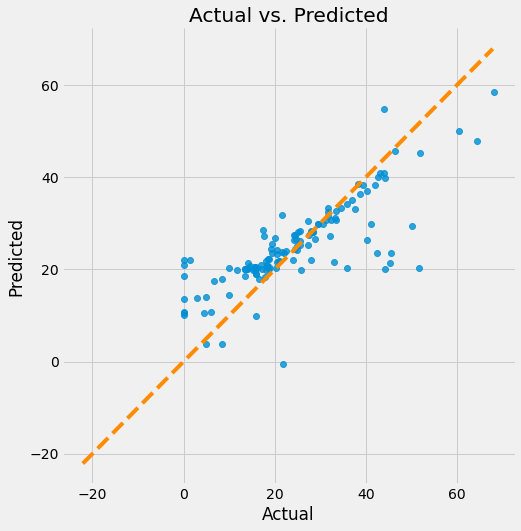

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 3.087262450363349e-10
Residuals are not normally distributed


/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


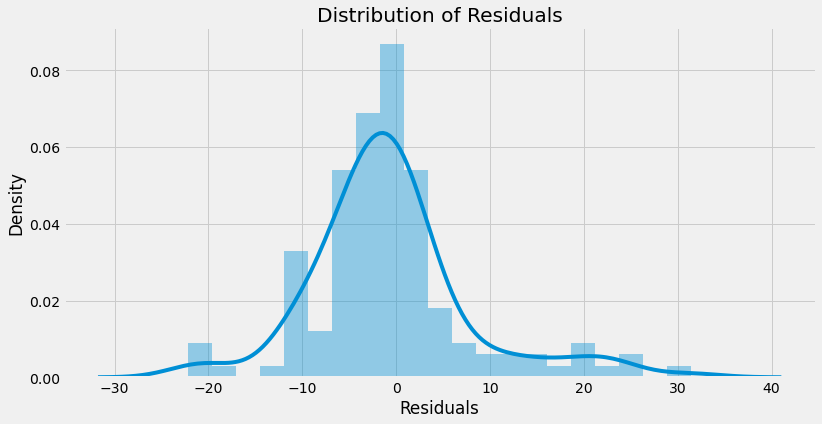


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables
Assumption 3: Little to no multicollinearity among predictors


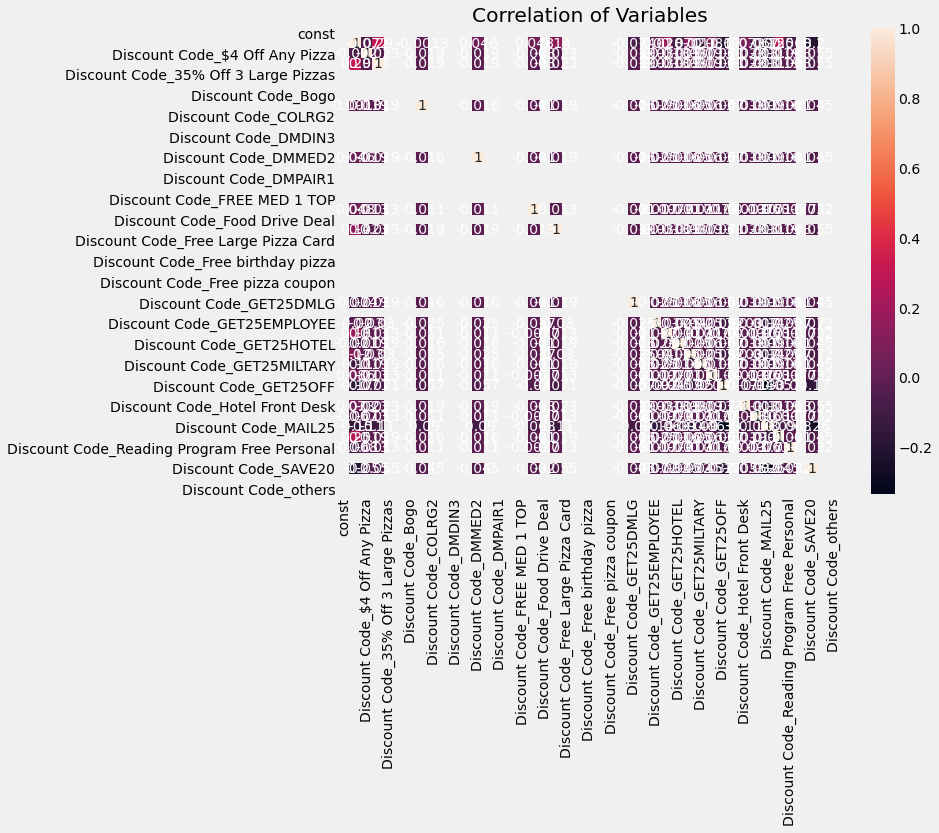

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------


/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


const: 3.196975065846481
Total Discount Amount: 1.0272721354006953
Discount Code_$4 Off Any Pizza: 1.2504353213604618
Discount Code_100% Off: nan
Discount Code_35% Off 3 Large Pizzas: nan
Discount Code_7-7-7 Deal: nan
Discount Code_Bogo: 1.0351866344766625
Discount Code_COLRG1: nan
Discount Code_COLRG2: nan
Discount Code_Coupon: nan
Discount Code_DMDIN3: 1.053457681941284
Discount Code_DMFAV1: nan
Discount Code_DMMED2: nan
Discount Code_DMMED3: nan
Discount Code_DMPAIR1: 1.0315289365920923
Discount Code_Employee Discount: nan
Discount Code_FREE MED 1 TOP: 1.1302495174164013
Discount Code_FREEMDM: nan
Discount Code_Food Drive Deal: nan
Discount Code_Free Birthday Pizza: nan
Discount Code_Free Large Pizza Card: nan
Discount Code_Free Large pizza coupon: nan
Discount Code_Free birthday pizza: nan
Discount Code_Free large pizza coupon: 1.0145033419570622
Discount Code_Free pizza coupon: 1.0784699593547302
Discount Code_Free pizza credit: 1.0890449559752706
Discount Code_GET25DMLG: 1.015164

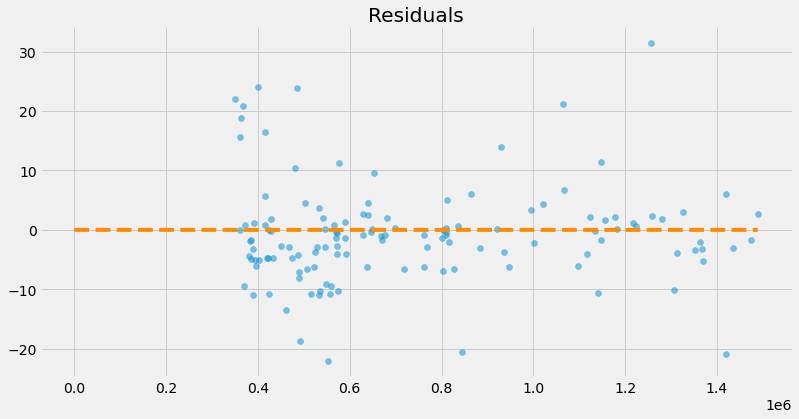

In [41]:
#check assumptions of final models 
names_list = list(X.columns)
calculate_residuals(voter3, X_test_rfe, y_test)
linear_assumption(voter3, X_test_rfe, y_test)
normal_errors_assumption(voter3, X_test_rfe, y_test, p_value_thresh=0.05)
multicollinearity_assumption(voter3, X_test_rfe, y_test, feature_names = names_list)
autocorrelation_assumption(voter3, X_test_rfe, y_test)
homoscedasticity_assumption(voter3, X_test_rfe, y_test)

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


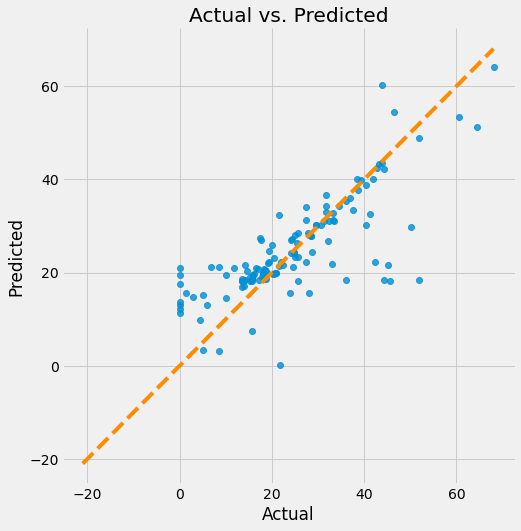

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 1.251905706240356e-11
Residuals are not normally distributed


/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


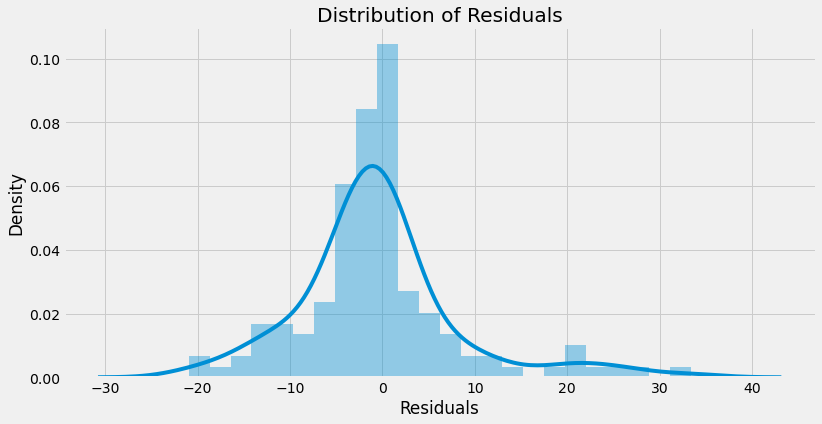


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables
Assumption 3: Little to no multicollinearity among predictors


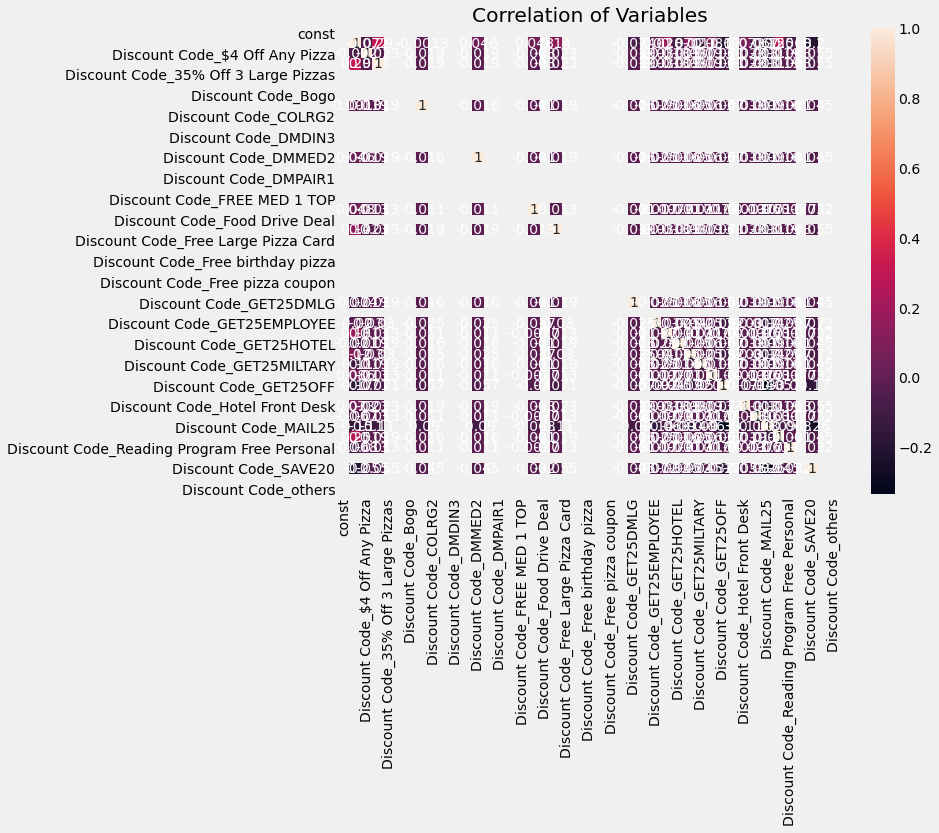

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
const: 3.196975065846481
Total Discount Amount: 1.0272721354006953
Discount Code_$4 Off Any Pizza: 1.2504353213604618
Discount Code_100% Off: nan
Discount Code_35% Off 3 Large Pizzas: nan
Discount Code_7-7-7 Deal: nan
Discount Code_Bogo: 1.0351866344766625
Discount Code_COLRG1: nan
Discount Code_COLRG2: nan
Discount Code_Coupon: nan
Discount Code_DMDIN3: 1.053457681941284
Discount Code_DMFAV1: nan
Discount Code_DMMED2: nan
Discount Code_DMMED3: nan
Discount Code_DMPAIR1: 1.0315289365920923
Discount Code_Employee Discount: nan
Discount Code_FREE MED 1 TOP: 1.1302495174164013
Discount Code_FREEMDM: nan
Discount Code_Food Drive Deal: nan
Discount Code_Free Birthday Pizza: nan
Discount Code_Free Large Pizza Card: nan
Discount Code_Free Large pizza coupon: nan
Discount Code_Free birthday pizza: nan
Discount Code

/Users/aeakland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


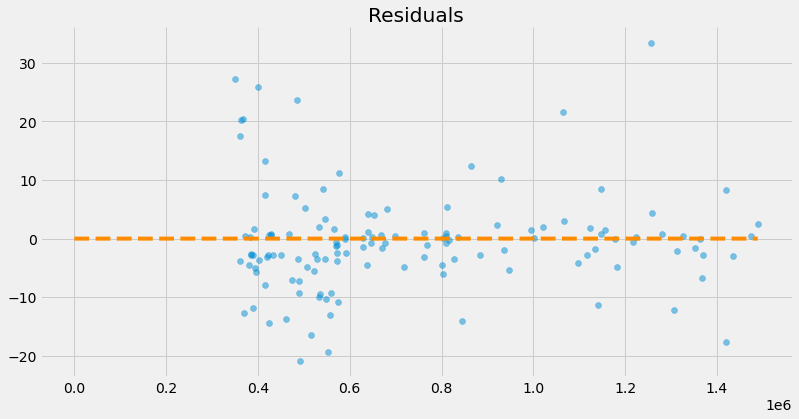

In [42]:
calculate_residuals(stacking_regressor, X_test_rfe, y_test)
linear_assumption(stacking_regressor, X_test_rfe, y_test)
normal_errors_assumption(stacking_regressor, X_test_rfe, y_test, p_value_thresh=0.05)
multicollinearity_assumption(stacking_regressor, X_test_rfe, y_test, feature_names = names_list)
autocorrelation_assumption(stacking_regressor, X_test_rfe, y_test)
homoscedasticity_assumption(stacking_regressor, X_test_rfe, y_test)

### Features and Coefficients
The code blocks below are dedicated to pulling out the important features and coefficient values from the models used in the VotingRegressor. Since the VotingRegressor is a meta-estimator and averages predictions from the estimators within it, there are no feature values or coefficients to pull out of the VotingRegressor model itself.

In [43]:
#Pulling the coefficient values from the tuned ridge regression used in the VotingRegressor
ridge_coef = {name: score 
                   for name, score 
                       in zip(X_train_val_rfe.columns, tuned_rr.coef_)
}
ridge_coef = pd.DataFrame(data=ridge_coef, index=range(len(ridge_coef)))
ridge_coef.drop_duplicates(inplace=True)
ridge_coef = ridge_coef.T
ridge_coef.rename(columns = {0: 'Value'}, inplace = True)
ridge_coef.sort_values(by='Value', ascending=False, inplace=True)
ridge_coef.head(10)

,Value
Discount Code_LARGEFAV,22.100885
Discount Code_SAVE20,21.434471
Discount Code_GET25MILTARY,17.450523
Discount Code_WINGS1,17.355759
Discount Code_DMPAIR1,15.963462
Discount Code_MAIL25,15.708687
Discount Code_GET25OFF,15.353581
Discount Code_$4 Off Any Pizza,15.077658
Discount Code_DMDIN3,14.535081
Discount Code_GET25MILITARY,14.527399


In [44]:
print(ridge_coef.tail(10))

                                           Value
Discount Code_Food Drive Deal         -11.244923
Discount Code_Bogo                    -11.985703
Discount Code_Free Birthday Pizza     -17.493109
Discount Code_100% Off                -20.076802
Discount Code_GET25FREE               -21.648042
Discount Code_Free Large Pizza Card   -24.494028
Discount Code_Free pizza coupon       -27.178891
Discount Code_Free birthday pizza     -27.229837
Discount Code_Free pizza credit       -32.029533
Discount Code_Free large pizza coupon -35.597136


In [45]:
#Grabbing top 10 important features from Tuned Random Forest using tuned_rf.feature_importances_
rf_feat_import = {name: score 
                   for name, score 
                       in zip(X_train_val_rfe.columns, tuned_rf.feature_importances_)
}
rf_feat_import = pd.DataFrame(data=rf_feat_import, index=range(len(rf_feat_import)))
rf_feat_import.drop_duplicates(inplace=True)
rf_feat_import = rf_feat_import.T
rf_feat_import.rename(columns = {0: 'Importance'}, inplace = True)
rf_feat_import.sort_values(by='Importance', ascending=False, inplace=True)
rf_feat_import.head(10)

,Importance
Total Discount Amount,0.555171
Discount Code_MAIL25,0.096765
Discount Code_GET25EMPLOYEE,0.092983
Discount Code_SAVE20,0.091955
Discount Code_GET25OFF,0.085919
Discount Code_DMPAIR1,0.024487
Discount Code_GET25MILITARY,0.022968
Discount Code_GET25HOTEL,0.013286
Discount Code_GET25MILTARY,0.004351
Discount Code_WINGS1,0.003310


In [46]:
#same process on the GradientBoosting Regressor using tuned_gb.feature_importances_
gb_feat_import = {name: score 
                   for name, score 
                       in zip(X_train_val_rfe.columns, tuned_gb.feature_importances_)
}
gb_feat_import = pd.DataFrame(data=gb_feat_import, index=range(len(gb_feat_import)))
gb_feat_import.drop_duplicates(inplace=True)
gb_feat_import = gb_feat_import.T
gb_feat_import.rename(columns = {0: 'Importance'}, inplace = True)
gb_feat_import.sort_values(by='Importance', ascending=False, inplace=True)
gb_feat_import.head(10)

,Importance
Total Discount Amount,0.525792
Discount Code_GET25EMPLOYEE,0.108812
Discount Code_MAIL25,0.085244
Discount Code_SAVE20,0.079622
Discount Code_GET25OFF,0.072594
Discount Code_100% Off,0.020333
Discount Code_GET25MILITARY,0.017157
Discount Code_Movers Free Medium,0.012765
Discount Code_GET25HOTEL,0.011265
Discount Code_DMPAIR1,0.010494


# Conclusion

### Top performing model is the VotingRegressor with an explained variance of 62% and R-Squared of 0.616. RMSE for this model is \\$8.53. 

### Final models selected were evaluated on the reduced sets after eliminating all risk of multicollinearity. With assumptions for normal distribution of residuals and homoscedasticity still in violation, it is important to note that the predictions of the model could potentially be skewed. Despite my best efforts to eliminate the violations on the homoscedasticity and normal distribution of residual assumptions, further iterations and collaboration with the stakeholder will be required to that end. Improved static reporting may improve the model results and reliability, as may more aggressive binning of the discount codes in the interim. 

#### Please see the Further Analysis and Limitations sections for more on this.

# Further Analysis 

#### Through this analysis, there have been many challenges. From the number of individual discount codes, to the complexity of the reports. For future steps, I would like to see if futher restricting the codes improves performance. While in the Final Modeling notebook, I did utilize RFE to identify the most valuable features to retain, I can't help but wonder if, perhaps, more aggressive binning of the codes together would yield better modeling results (i.e. get all employee type discounts together, all mailer discounts together, all virtual discounts together, etc). With there being so many individual codes, it may be worthy to explore a more aggressive approach to grouping them. I also see some misspelled codes popping up that had not been caught during the cleaning process, which created duplicates in a sense, so those would need to be better addressed in future analysis as well. Furthermore, there may be something to be said about specific items and their respective sales volumes or values. That would also be a step I'd like to explore in the future with additional time for analysis. Perhaps a particular item or class would be a better predictor of net sales over discounts codes and values, or even in combination with these predictors, should I find an optimal binning strategy.

#### More time and data is also going to be necessary for future analysis with regard to the marketing strategy specifically. In order to better identify best marketing strategy, I will need more marketing data in order to model. With there only being a few lines of marketing costs to quantify, I will need to rethink my feature engineering in absence of a sufficient amount of data for modeling those avenues. While I could not model them, I do think I can provide some useful information to the stakeholder just utilizing inferential statistics strategies.
##### For example, with regard to the Facebook Marketing approach specifically. Per my conversation with the stakeholder and from my analysis in the EDA section of the data cleaning notebook, normal order volume has a median of 57 orders per day and an arithmetic mean of ~60. The average order value on a given day is approximately \\$27.33, and the maximum order day seen in this dataset had an order count of 223 and an average order value far below the mean at only \\$10.70. Assuming that this day was the Facebook promo day that the stakeholder mentioned, the jump from the median of 57 orders to 223 orders represents a 291.23% increase for a cost of \\$300. Applying the same idea utilized for the other marketing avenues, an increase in responses by 166 customers from the normal ~57 to the observed 223 orders at a cost of \\$300 represents a cost of ~\\$1.81 per response and by far the lowest cost by marketing type observed in this analysis. The stakeholder acknowledged that there are staffing concerns to work out, as this influx overwhelmed their capabilities, but it seems a worthy path for further exploration.

#### And finally, I believe that utilizing the Yelp API, and possibly other APIs, in combination with NLP strategies to analyze customer sentiment and reviews would be insightful. There is much to glean from customer sentiment, both good and bad, and is definitely something I would like to explore in future analysis.

## Limitations

As mentioned in the sections above, limitations of this analysis are going to be tied to the violations of the linear regression assumptions - specifically homoscedasticity, multicollinearity, and normal distribution of the residuals. Despite the correction attempts made in the final modeling notebook, I was unable to resolve the homoscedasticity and normality of the residuals, though multicollinearity between the predictors was completely eliminated. Log transformations, scaling, and feature elimination were methods attempted to normalize and correct. As an additional step in my future analysis, I will remove the outliers present in the data as a final attempt to normalize the set, and evaluate the assumptions and performance again. Visually inspecting the predictions against the actuals, and the residual plots, I am hopeful that the removal of the outliers will be helpful in improving overall model performance and satisfying all assumptions.

As seen here on our distribution of residuals, our model may be biasing towards underestimating. With this in mind, and the homoscedasticity assumption in question, our model is more likely to weigh coefficients statistically significant, when they may not actually be. While I don't see a cone shape that would indicate obvious heteroscedasticity, there is not clearly consistent variance in our residuals, and I am therefore hesitant to trust our model's coefficient values until these assumptions are satisfied. 